In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.applications import ResNet152V2, EfficientNetV2M
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Preprocessing function for loading and resizing images
def load_and_preprocess_image(base_dir, path, target_size=(64, 64)):
    img_path = os.path.join(base_dir, path.replace('\\', '/'))
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    return img_array

def preprocess_resnet(input_image):
    # Preprocessing for ResNet152V2
    return tf.keras.applications.resnet_v2.preprocess_input(input_image)

def preprocess_efficientnet(input_image):
    # Preprocessing for EfficientNetV2M
    return tf.keras.applications.efficientnet_v2.preprocess_input(input_image)

In [4]:
# Function to load and preprocess data
def get_data_for_training(excel_path, base_dir, image_size=(64, 64)):
    df = pd.read_excel(excel_path)
    df = df.dropna(subset=['image_path'])
    class_names = df.columns[2:]  # Assuming class columns start from the 3rd column
    X = np.array([load_and_preprocess_image(base_dir, path, image_size) for path in df['image_path'].values])
    
    # Rescale images according to model-specific preprocessing
    X_resnet = np.array([preprocess_resnet(img) for img in X])
    X_efficientnet = np.array([preprocess_efficientnet(img) for img in X])
    
    y = df[class_names].values
    return X_resnet, X_efficientnet, y, df['image_path'].values # Function to build ResNet152V2 base model

# Function to build ResNet152V2 base model
def build_resnet152v2_base(input_shape=(64, 64, 3)):
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)
    output = GlobalAveragePooling2D()(base_model.output)
    return Model(inputs=base_model.input, outputs=output)

# Function to build EfficientNetV2M base model
def build_efficientnetv2m_base(input_shape=(64, 64, 3)):
    base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=input_shape)
    output = GlobalAveragePooling2D()(base_model.output)
    return Model(inputs=base_model.input, outputs=output)


In [5]:
# Function to build the ensemble model with custom layers
def build_ensemble_model(resnet_base, efficientnet_base, num_classes=10):
    # Define inputs for both models
    input_resnet = Input(shape=resnet_base.input_shape[1:])
    input_efficientnet = Input(shape=efficientnet_base.input_shape[1:])
    
    # Extract feature maps from both models
    resnet_features = resnet_base(input_resnet)
    efficientnet_features = efficientnet_base(input_efficientnet)
    
    # Concatenate the features
    concatenated_features = Concatenate()([resnet_features, efficientnet_features])
    
    # Add custom dense layers
    x = Dense(2048, activation="gelu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(concatenated_features)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation="gelu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation="gelu")(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation="gelu")(x)
    output = Dense(num_classes, activation="softmax")(x)  # Multi-class classification
    
    # Build the ensemble model
    ensemble_model = Model(inputs=[input_resnet, input_efficientnet], outputs=output)
    ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return ensemble_model


In [7]:
# Load and preprocess data
train_excel_path = "/kaggle/input/mlproject/Dataset/training/training_data.xlsx"
val_excel_path = "/kaggle/input/mlproject/Dataset/validation/validation_data.xlsx"
base_dir = "/kaggle/input/mlproject/Dataset"

# Load the training and validation data
X_train_resnet, X_train_efficientnet, y_train, _ = get_data_for_training(train_excel_path, base_dir, image_size=(64, 64))
X_val_resnet, X_val_efficientnet, y_val, _ = get_data_for_training(val_excel_path, base_dir, image_size=(64, 64))


In [10]:
print(f"X_train: {X_train_resnet.shape}, y_train: {y_train.shape}")
print(f"X_train: {X_val_resnet.shape}, y_train: {y_val.shape}")

X_train: (37607, 64, 64, 3), y_train: (37607, 10)
X_train: (16132, 64, 64, 3), y_train: (16132, 10)


In [11]:
print(f"X_train: {X_train_efficientnet.shape}, y_train: {y_train.shape}")
print(f"X_train: {X_val_efficientnet.shape}, y_train: {y_val.shape}")

X_train: (37607, 64, 64, 3), y_train: (37607, 10)
X_train: (16132, 64, 64, 3), y_train: (16132, 10)


In [14]:
# Build base models with new input shape
resnet_base = build_resnet152v2_base(input_shape=(64, 64, 3))
efficientnet_base = build_efficientnetv2m_base(input_shape=(64, 64, 3))

# Build the ensemble model
ensemble_model = build_ensemble_model(resnet_base, efficientnet_base)


In [16]:
ensemble_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 2048)      │ 58,331,648 │ input_layer_6[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 1280)      │ 53,150,388 │ input_layer_7[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3328)      │          0 │ functional_7[0][… │
│ (Concatenate)       │                   │            │ functional_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2048)      │  6,817,792 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2048)      │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1024)      │  2,098,176 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1024)      │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    524,800 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    131,328 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10)        │      2,570 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 121,056,702 (461.79 MB)

 Trainable params: 120,620,926 (460.13 MB)

 Non-trainable params: 435,776 (1.66 MB)

In [17]:
from tensorflow.keras import callbacks

# Define callbacks for training
lr_callback = callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=5,
    mode="auto",
    min_delta=0.0001,
    restore_best_weights=True
)

es_transfer = callbacks.EarlyStopping(
monitor='val_accuracy',
patience=10,  # Stop after 5 epochs of no improvement
restore_best_weights=True
)

# EarlyStopping for Partial Fine-Tuning (Unfreeze Top Layers)
es_partial_fine_tune = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=12,  # Allow slightly more room for improvement
    restore_best_weights=True
)

# EarlyStopping for Full Fine-Tuning (Unfreeze Entire Base Model)
es_full_fine_tune = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,  # Allow more patience for the fine-tuning phase
    restore_best_weights=True
)

#checkpoint_filepath = '/kaggle/working/CheckPoints/ResNet152V2/final_model.keras'
checkpoint_filepath = '/kaggle/working/CheckPoints/Ensemble/modellast.weights.h5'

chk_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True, 
    mode='auto',
    verbose=1
)

In [17]:
# Training Phase 1: Frozen Base Models
LEARNING_RATE = 1e-3
BATCH_SIZE = 16  # Set batch size to 16 for all phases
with tf.device('/gpu:0'):
    # Freeze both base models
    resnet_base.trainable = False
    efficientnet_base.trainable = False

    ensemble_model.compile(
        optimizer=tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.CategoricalCrossentropy(),  
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
    )
    print("Phase 1: Training with Frozen Base Models")
    history_phase1 = ensemble_model.fit(
        x=[X_train_resnet, X_train_efficientnet],
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=30,
        validation_data=([X_val_resnet, X_val_efficientnet], y_val),
        callbacks=[lr_callback, es_transfer, chk_callback]
    )

Phase 1: Training with Frozen Base Models
Epoch 1/30


I0000 00:00:1732230519.350375     248 service.cc:145] XLA service 0x7ccb9c0030c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732230519.350428     248 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   1/2351 ━━━━━━━━━━━━━━━━━━━━ 98:40:58 151s/step - accuracy: 0.1250 - loss: 6.6002

I0000 00:00:1732230625.855948     248 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2351/2351 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7595 - loss: 2.9630
Epoch 1: saving model to /kaggle/working/CheckPoints/Ensemble/modellast.weights.h5
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 440s 123ms/step - accuracy: 0.7595 - loss: 2.9627 - val_accuracy: 0.7956 - val_loss: 1.3045 - learning_rate: 0.0010
Epoch 2/30
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8020 - loss: 1.1604
Epoch 2: saving model to /kaggle/working/CheckPoints/Ensemble/modellast.weights.h5
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 163s 69ms/step - accuracy: 0.8020 - loss: 1.1603 - val_accuracy: 0.7843 - val_loss: 0.9322 - learning_rate: 0.0010
Epoch 3/30
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8186 - loss: 0.8235
Epoch 3: saving model to /kaggle/working/CheckPoints/Ensemble/modellast.weights.h5
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 159s 67ms/step - accuracy: 0.8186 - loss: 0.8235 - val_accuracy: 0.7959 - val_loss: 0.8090 - learning_rate: 0.0010
Epoch 4/30
2350/2351 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step -

In [18]:
# Training Phase 2: Partial Fine-Tuning
LEARNING_RATE = 1e-4
with tf.device('/gpu:0'):
    # Unfreeze last layers of ResNet152V2 and EfficientNetV2M
    for layer in resnet_base.layers[-60:]:
        layer.trainable = True
    for layer in resnet_base.layers[:-60]:
        layer.trainable = False

    for layer in efficientnet_base.layers[-200:]:
        layer.trainable = True
    for layer in efficientnet_base.layers[:-200]:
        layer.trainable = False

    ensemble_model.compile(
        optimizer=tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.CategoricalCrossentropy(),  # Removed from_logits=False
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
    )
    print("Phase 2: Partial Fine-Tuning with Top Layers Unfrozen")
    history_partial_finetune = ensemble_model.fit(
        x=[X_train_resnet, X_train_efficientnet],
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=([X_val_resnet, X_val_efficientnet], y_val),
        callbacks=[lr_callback, es_partial_fine_tune, chk_callback]
    )


Phase 2: Partial Fine-Tuning with Top Layers Unfrozen
Epoch 1/30
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7884 - loss: 0.8504
Epoch 1: saving model to /kaggle/working/CheckPoints/Ensemble/modellast.weights.h5
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 626s 171ms/step - accuracy: 0.7884 - loss: 0.8504 - val_accuracy: 0.8225 - val_loss: 0.7232 - learning_rate: 1.0000e-04
Epoch 2/30
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8460 - loss: 0.5993
Epoch 2: saving model to /kaggle/working/CheckPoints/Ensemble/modellast.weights.h5
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 235s 100ms/step - accuracy: 0.8460 - loss: 0.5993 - val_accuracy: 0.8363 - val_loss: 0.6580 - learning_rate: 1.0000e-04
Epoch 3/30
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8728 - loss: 0.5053
Epoch 3: saving model to /kaggle/working/CheckPoints/Ensemble/modellast.weights.h5
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 236s 100ms/step - accuracy: 0.8728 - loss: 0.5053 - val_accuracy: 0.8388 - val_loss: 0.6656 - le

In [18]:
ensemble_model.load_weights('/kaggle/working/CheckPoints/Ensemble/modellast.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 478 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Training Phase 3: Full Fine-Tuning
LEARNING_RATE = 5e-6
BATCH_SIZE = 8  
with tf.device('/gpu:0'):
    # Unfreeze all layers in both base models
    resnet_base.trainable = True
    efficientnet_base.trainable = True

    ensemble_model.compile(
        optimizer=tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.CategoricalCrossentropy(),  
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
    )
    print("Phase 3: Fine-Tuning with Unfrozen Base Models")
    history_phase3 = ensemble_model.fit(
        x=[X_train_resnet, X_train_efficientnet],
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=8,
        validation_data=([X_val_resnet, X_val_efficientnet], y_val),
        callbacks=[lr_callback, es_full_fine_tune, chk_callback]  
    )

Phase 3: Fine-Tuning with Unfrozen Base Models


In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the validation set
y_pred = ensemble_model.predict([X_val_resnet, X_val_efficientnet])
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

505/505 ━━━━━━━━━━━━━━━━━━━━ 65s 87ms/step


In [ ]:

# Save validation predictions to an Excel file
results_df = pd.DataFrame({
    'Image_path': _,
    'actual_class': y_val_classes, 
    'predicted_class': y_pred_classes
})

results_file_path = os.path.join('/kaggle/working', "results.xlsx")
# Save the file
results_df.to_excel(results_file_path, index=False, sheet_name='Sheet1')

print(f"Results saved to: {results_file_path}")



Confusion Matrix:
[[0.5694165  0.01006036 0.15291751 0.02012072 0.01006036 0.01006036
  0.19517103 0.02816901 0.         0.00402414]
 [0.01114206 0.61002786 0.10306407 0.03064067 0.01392758 0.00278552
  0.18384401 0.0362117  0.00278552 0.00557103]
 [0.03290043 0.03116883 0.54025974 0.05800866 0.02597403 0.01385281
  0.22857143 0.05974026 0.00606061 0.0034632 ]
 [0.02356902 0.01683502 0.26936027 0.36700337 0.02693603 0.003367
  0.20538721 0.08080808 0.         0.00673401]
 [0.00588235 0.00294118 0.05588235 0.01764706 0.76470588 0.01176471
  0.09705882 0.03529412 0.00294118 0.00588235]
 [0.02623907 0.02040816 0.10495627 0.0058309  0.02040816 0.64723032
  0.12827988 0.04081633 0.00291545 0.00291545]
 [0.00390657 0.00227883 0.02319525 0.00390657 0.0018719  0.00203467
  0.95515586 0.00512737 0.00130219 0.0012208 ]
 [0.036      0.026      0.186      0.076      0.018      0.01
  0.298      0.342      0.002      0.006     ]
 [0.00699301 0.         0.0034965  0.         0.         0.
  0.048951

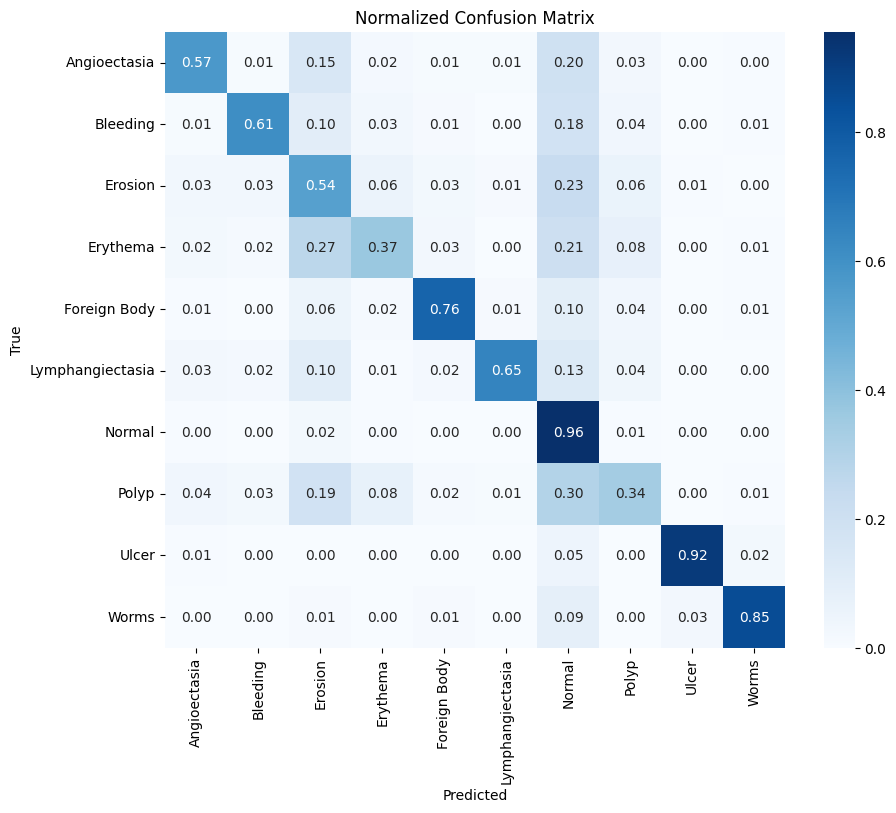

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       497
           1       0.70      0.61      0.65       359
           2       0.50      0.54      0.52      1155
           3       0.37      0.37      0.37       297
           4       0.75      0.76      0.76       340
           5       0.80      0.65      0.71       343
           6       0.94      0.96      0.95     12287
           7       0.45      0.34      0.39       500
           8       0.90      0.92      0.91       286
           9       0.60      0.85      0.71        68

    accuracy                           0.86     16132
   macro avg       0.67      0.66      0.66     16132
weighted avg       0.86      0.86      0.86     16132



In [24]:
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_val_classes, y_pred_classes, normalize='true')
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_val_classes, y_pred_classes))

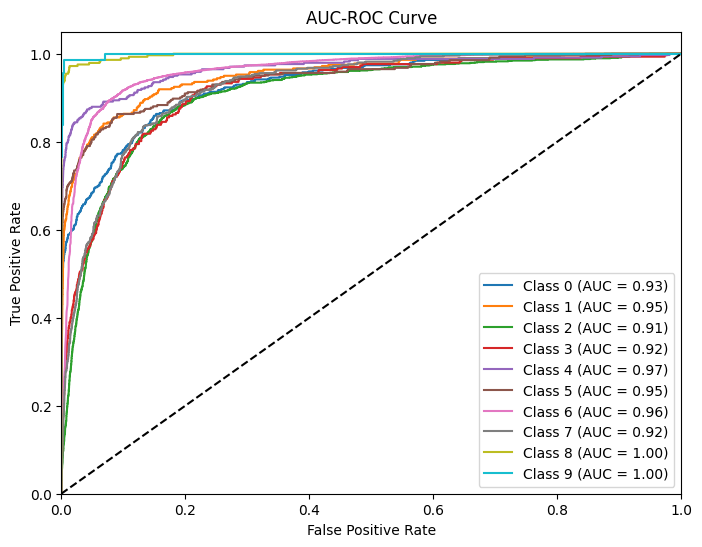

In [25]:

# Plot AUC-ROC curve
lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_pred[:, i])

# Plot AUC-ROC for each class
plt.figure(figsize=(8, 6))
for i in range(len(lb.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()